# Salinity budget

This notebook reproduces Fig. 3 for Ford and Rose (submitted 2025). 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt, correlate, correlation_lags
from cartopy import crs as ccrs, feature as cfeature
import numpy as np
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy.stats import pearsonr

In [2]:
def detrend_dim(da, dim, deg=1):
    mean = da.mean(dim=dim)
    anom = da - mean
    p = anom.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(anom[dim], p.polyfit_coefficients)
    return da - fit
    
def normalize(da, dim='time'):
    return (da - da.mean(dim=dim))/da.std(dim=dim)

def center(da, dim='time'):
    return da - da.mean(dim=dim)

def lpf(data, cutoff, fs, order=2, pad_len=100):
    b, a = butter(order, cutoff / (0.5 * fs), btype='low')

    # Padding
    pad_left = data[1:pad_len+1][::-1]
    pad_right = data[-pad_len-1:-1][::-1]
    padded = np.concatenate([pad_left, data, pad_right])

    filtered_padded = filtfilt(b, a, padded)
    return filtered_padded[pad_len:-pad_len]

def lpf_ufunc(da, cutoff_years=10, order=2, pad_len=100):
    fs = 1.0  # Monthly data
    cutoff = 1 / (cutoff_years * 12)

    return xr.apply_ufunc(lpf, da, kwargs={"cutoff": cutoff, "fs": fs, "order": order, "pad_len": pad_len})

def rolling_mean(da, t=120):
    return da.rolling(time=t, center=True).mean().dropna('time')

def annual_rm(da, t=10):
    return da.resample(time='1YE').mean().isel(time=slice(1, -1)).rolling(time=t, center=True).mean()

def annual(da):
    return da.resample(time='1YE').mean().isel(time=slice(1, -1))

def calc_xcorr(x, y, mode='full'): 
    n = len(x)
    x = x - np.mean(x)
    y = y - np.mean(y)
    norm = np.std(x) * np.std(y) * len(x)
    c = correlate(x, y, mode)
    c = c/norm
    return c

def conv_box(da, vert=True):
    da_region = da.where((da.TLAT >= -69) & (da.TLAT <= -64) & ((da.TLONG >= 354) | (da.TLONG <= 19)), drop=True)
    if vert == True:
        return da_region.isel(z_t=slice(0, 5)).load()
    else: return da_region.load()

## Load data

In [3]:
# salt_crb_ds = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-CRB-SALT-full.nc')
tend_salt_crb_ds = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-CRB-TEND_SALT-full.nc')
hmxl_crb_ds = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-CRB-HMXL-full.nc')
sfwf_crb_ds = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-CRB-SFWF-full.nc')
qflux_crb_ds = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-CRB-QFLUX-full.nc')
adv_crb_ds = xr.open_dataset('/roselab_rit/rford/iHESP-data/salinity_budget_adv.nc')

In [4]:
# Advection calculated using xgcm:
uadv2 = xr.open_dataset('/roselab_rit/rford/iHESP-data/u_adv_ts2.nc').u_adv
vadv2 = xr.open_dataset('/roselab_rit/rford/iHESP-data/v_adv_ts2.nc').v_adv
wadv2 = xr.open_dataset('/roselab_rit/rford/iHESP-data/w_adv_ts2.nc').w_adv

In [5]:
cr_salt_ts_ds = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-CR-SALT-50m-ts.nc')

In [6]:
tarea_ds = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-POP-TAREA-HRM.nc')

In [7]:
tarea = conv_box(tarea_ds.TAREA, vert=False)

In [8]:
grid_vars = xr.open_dataset('/roselab_rit/rford/iHESP-data/grid-vars.nc')

In [9]:
tend_salt_crb_ds

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 2184, z_t: 11, nlat: 118, nlon: 250)
Coordinates:
  * time       (time) object 17kB 0338-02-01 00:00:00 ... 0520-01-01 00:00:00
  * z_t        (z_t) float32 44B 500.0 1.5e+03 2.5e+03 ... 9.5e+03 1.05e+04
    ULONG      (nlat, nlon) float64 236kB ...
    ULAT       (nlat, nlon) float64 236kB ...
    TLONG      (nlat, nlon) float64 236kB ...
    TLAT       (nlat, nlon) float64 236kB ...
Dimensions without coordinates: nlat, nlon
Data variables:
    TEND_SALT  (time, z_t, nlat, nlon) float32 3GB ...

In [10]:
grid_vars

<xarray.Dataset> Size: 415MB
Dimensions:             (z_t: 62, nlat: 2400, nlon: 3600)
Coordinates:
  * z_t                 (z_t) float32 248B 500.0 1.5e+03 ... 5.625e+05 5.875e+05
    ULONG               (nlat, nlon) float64 69MB ...
    ULAT                (nlat, nlon) float64 69MB ...
    TLONG               (nlat, nlon) float64 69MB ...
    TLAT                (nlat, nlon) float64 69MB ...
Dimensions without coordinates: nlat, nlon
Data variables:
    dz                  (z_t) float32 248B ...
    DXT                 (nlat, nlon) float64 69MB ...
    DYT                 (nlat, nlon) float64 69MB ...
    latent_heat_fusion  float64 8B ...
    salinity_factor     float64 8B ...
Attributes: (12/13)
    title:           B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02
    history:         Sat Jul 24 16:05:33 2021: ncap2 -A -s time=udunits(time,...
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    ...              ...
    start_time:      This dataset was created on 2019-11-12 at 02:38:21.0
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    70397171
    tavg_sum:        2678400.0
    tavg_sum_qflux:  2678400.0
    NCO:             netCDF Operators version 4.8.1 (Homepage = http://nco.sf...

In [11]:
lhf = grid_vars.latent_heat_fusion.values
sfactor = grid_vars.salinity_factor.values

In [12]:
sfactor

array(-0.00347)

In [13]:
spy = 60*60*24*365

In [14]:
dx = conv_box(grid_vars.DXT, vert=False)
dy = conv_box(grid_vars.DYT, vert=False)
dz = grid_vars.dz.isel(z_t=slice(0, 5))
dz6 = grid_vars.dz.isel(z_t=slice(0, 6))

In [15]:
vol = dx * dy * dz
vol_w = dx * dy * dz6
vol_w['z_t'] = vol_w['z_t'] - 500.

In [16]:
hr_jlfca = xr.open_dataset('/roselab_rit/rford/iHESP-data/iHESP-HR.PICTRL.SO-JLFCA.1x1.nc')

lfc0 = hr_jlfca.LFC.isel(mode=0, var=0).rolling(time=120, center=True).mean()
lfc1 = hr_jlfca.LFC.isel(mode=1, var=0).rolling(time=120, center=True).mean()

lfc0_max = find_peaks(lfc0, distance=400)[0]
lfc0_min = find_peaks(-lfc0, distance=430)[0][1:] # Exclude first min because it's too close to the edge for compositing

lfc1_max = find_peaks(lfc1, distance=400)[0]
lfc1_min = find_peaks(-lfc1, distance=430)[0]

In [17]:
def plot_lfc_ext(n=6, ax=None):
    if ax is None:
        for i in range(n):
            plt.axvline(lfc0.time.isel(time=lfc0_max).values[-(i+1)], color='k', alpha=0.4)
            plt.axvline(lfc0.time.isel(time=lfc0_min).values[-(i+1)], linestyle='--', color='k', alpha=0.4)

    else:
        for i in range(n):
            ax.axvline(lfc0.time.isel(time=lfc0_max).values[-(i+1)], color='k', alpha=0.4)
            ax.axvline(lfc0.time.isel(time=lfc0_min).values[-(i+1)], linestyle='--', color='k', alpha=0.4)

## Analysis

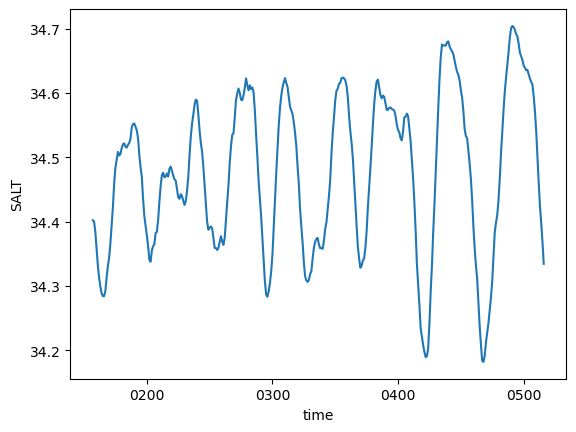

In [18]:
annual(cr_salt_ts_ds.SALT).rolling(time=10, center=True).mean().plot()

In [19]:
mld_subset = hmxl_crb_ds.HMXL.sel(time=slice('0338-02', None))

In [20]:
mld_clim = mld_subset.mean(dim='time')/100

In [21]:
mld_clim

<xarray.DataArray 'HMXL' (nlat: 118, nlon: 250)> Size: 118kB
array([[ 74.748055,  74.45997 ,  74.01713 , ..., 100.85103 , 100.605095,
        100.618996],
       [ 73.99579 ,  73.976166,  73.54611 , ...,  99.61861 ,  99.58967 ,
         99.7114  ],
       [ 73.09377 ,  73.0193  ,  72.71904 , ...,  98.123886,  97.97688 ,
         97.95385 ],
       ...,
       [ 88.38488 ,  88.39866 ,  88.70721 , ..., 112.62723 , 112.15712 ,
        112.05083 ],
       [ 87.848145,  88.131546,  88.07262 , ..., 111.33054 , 110.99693 ,
        110.94531 ],
       [ 87.3127  ,  87.47205 ,  87.73923 , ..., 110.36798 , 110.01718 ,
        109.64039 ]], shape=(118, 250), dtype=float32)
Coordinates:
    ULONG    (nlat, nlon) float64 236kB ...
    ULAT     (nlat, nlon) float64 236kB ...
    TLONG    (nlat, nlon) float64 236kB ...
    TLAT     (nlat, nlon) float64 236kB ...
Dimensions without coordinates: nlat, nlon

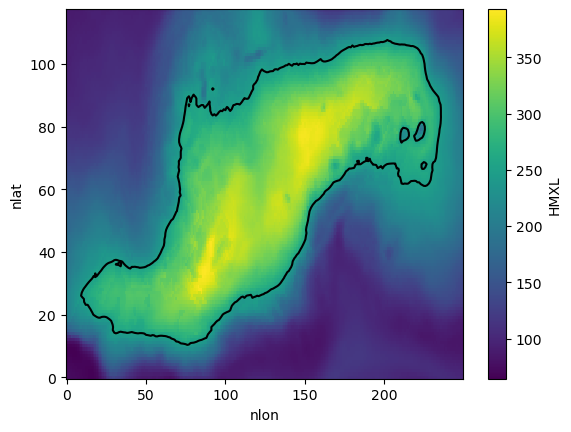

In [22]:
mld_clim.plot()
mld_clim.plot.contour(colors='k', levels=[250])

In [23]:
crmask = xr.where(mld_clim >= 250, 1, 0)

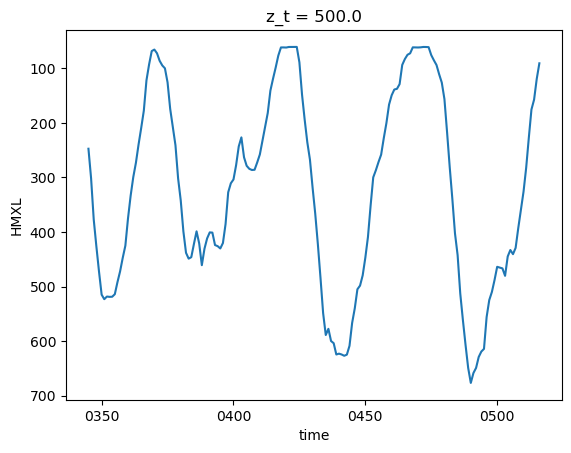

In [24]:
annual(mld_subset.where(crmask).weighted(tarea).mean(dim=['nlat', 'nlon'])/100).rolling(time=10, center=True).mean().plot(yincrease=False)

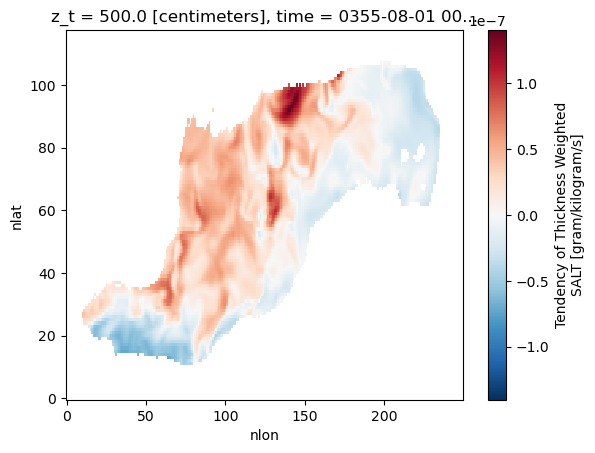

In [25]:
tend_salt_crb_ds.TEND_SALT.isel(z_t=0, time=210).where(crmask).plot()

In [26]:
crb_dsdt_ts = annual(tend_salt_crb_ds.TEND_SALT.isel(z_t=slice(0, 5)).where(crmask).weighted(tarea).mean(dim=['nlat', 'nlon']).mean(dim='z_t'))

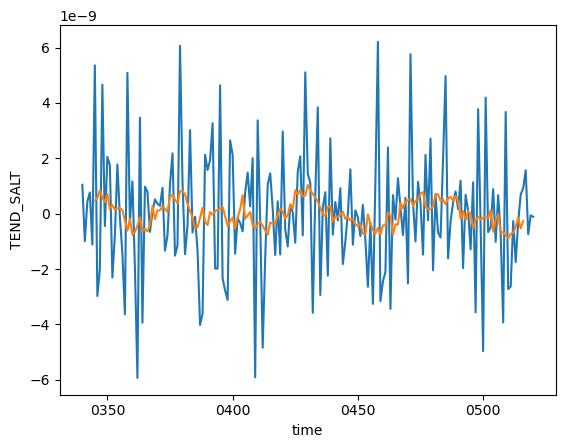

In [27]:
crb_dsdt_ts.plot()
crb_dsdt_ts.rolling(time=10, center=True).mean().plot()

In [28]:
sfwf_crb_ds.SFWF

<xarray.DataArray 'SFWF' (time: 3240, nlat: 118, nlon: 250)> Size: 382MB
[95580000 values with dtype=float32]
Coordinates:
  * time     (time) object 26kB 0250-02-01 00:00:00 ... 0520-01-01 00:00:00
    ULONG    (nlat, nlon) float64 236kB ...
    ULAT     (nlat, nlon) float64 236kB ...
    TLONG    (nlat, nlon) float64 236kB ...
    TLAT     (nlat, nlon) float64 236kB ...
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Virtual Salt Flux in FW Flux formulation
    units:         kg/m^2/s
    grid_loc:      2110
    cell_methods:  time: mean

kgFW/m^2/s * m^3/kgFW (1/1000) --> m/s

In [29]:
-0.1*0.0347 # salinity_factor uses cm and msu

-0.0034700000000000004

In [30]:
sfactor

array(-0.00347)

In [31]:
# Convert from kgFW/m^2/s to psu/s. The "salinity factor" seems to convert to msu*cm/s (model salinity units; g/g)
# sfc_flux_50m = sfactor*(sfwf_crb_ds.SFWF - qflux_crb_ds.QFLUX/(1e4*lhf))/50
sfc_flux_50m = -0.0347*(sfwf_crb_ds.SFWF - qflux_crb_ds.QFLUX/(1e4*lhf))/50

In [32]:
sfc_flux_50m_ts = annual(sfc_flux_50m.where(crmask).weighted(tarea).mean(dim=['nlon', 'nlat']).sel(time=slice('0338-02-01', None)))

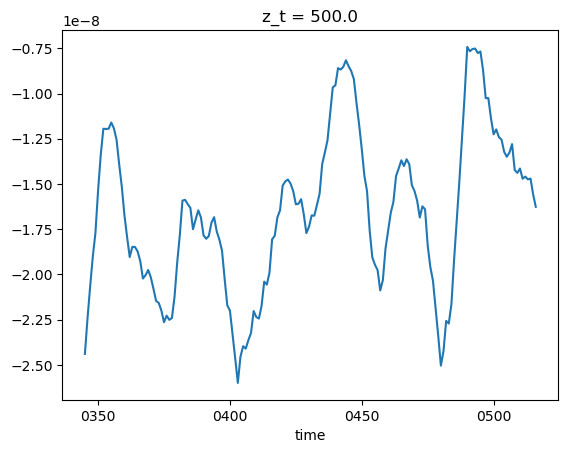

In [33]:
sfc_flux_50m_ts.rolling(time=10, center=True).mean().plot()

In [34]:
div_u = adv_crb_ds.UDIV
div_v = adv_crb_ds.VDIV
div_w = adv_crb_ds.WDIV
div = div_u + div_v + div_w

In [35]:
advection_ts = annual(div.where(crmask).weighted(tarea).mean(dim=['nlon', 'nlat', 'z_t']))

In [36]:
advection_ts2 = annual(uadv2.sel(time=slice('0338-02', None)) + vadv2.sel(time=slice('0338-02', None)) + wadv2.sel(time=slice('0338-02', None)))
horiz_adv_ts2 = annual(uadv2.sel(time=slice('0338-02', None)) + vadv2.sel(time=slice('0338-02', None)))
vert_adv_ts2 = annual(wadv2.sel(time=slice('0338-02', None)))

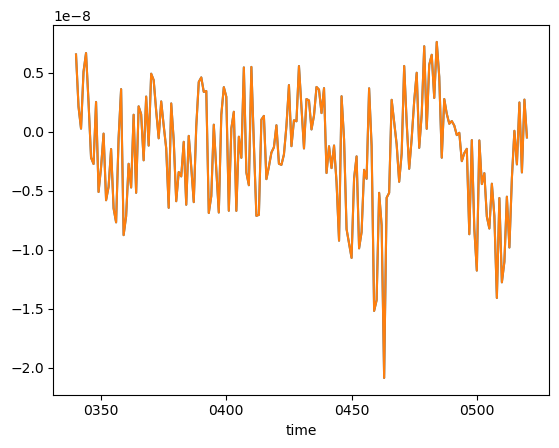

In [37]:
advection_ts.plot()
advection_ts2.plot()

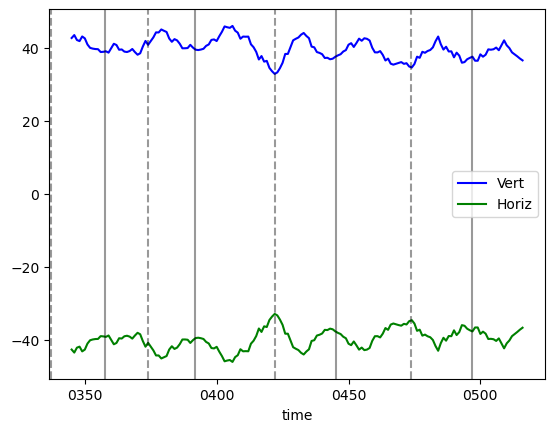

In [38]:
(spy*(vert_adv_ts2.rolling(time=10, center=True).mean())).plot(color='b', label='Vert')
(spy*(horiz_adv_ts2.rolling(time=10, center=True).mean())).plot(color='g', label='Horiz')
plt.legend()
plot_lfc_ext(4)

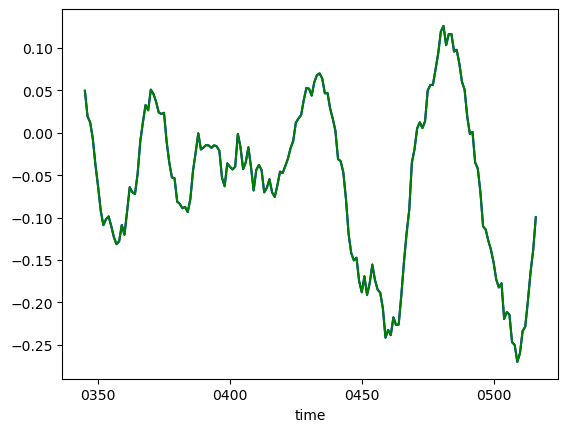

In [39]:
(spy*(advection_ts.rolling(time=10, center=True).mean())).plot(color='b', label='Advection')
(spy*(advection_ts2.rolling(time=10, center=True).mean())).plot(color='g', label='Advection')

In [40]:
vert_adv_ts = annual(div_w.where(crmask).weighted(tarea).mean(dim=['nlon', 'nlat', 'z_t']))

In [41]:
horiz_adv_ts = annual((div_u + div_v).where(crmask).weighted(tarea).mean(dim=['nlon', 'nlat', 'z_t']))
u_adv_ts = annual((div_u).where(crmask).weighted(tarea).mean(dim=['nlon', 'nlat', 'z_t']))
v_adv_ts = annual((div_v).where(crmask).weighted(tarea).mean(dim=['nlon', 'nlat', 'z_t']))

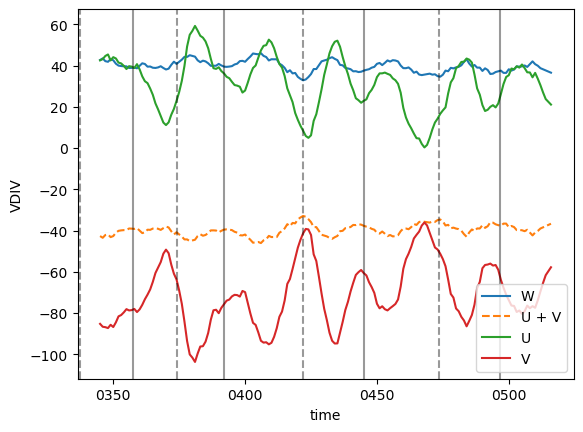

In [42]:
(spy*vert_adv_ts).rolling(time=10, center=True).mean().plot(label='W')
(spy*horiz_adv_ts).rolling(time=10, center=True).mean().plot(label='U + V', linestyle='--')
(spy*u_adv_ts).rolling(time=10, center=True).mean().plot(label='U')
(spy*v_adv_ts).rolling(time=10, center=True).mean().plot(label='V')
plt.legend()
plot_lfc_ext(4)

In [43]:
residual_ts = crb_dsdt_ts - sfc_flux_50m_ts - advection_ts2

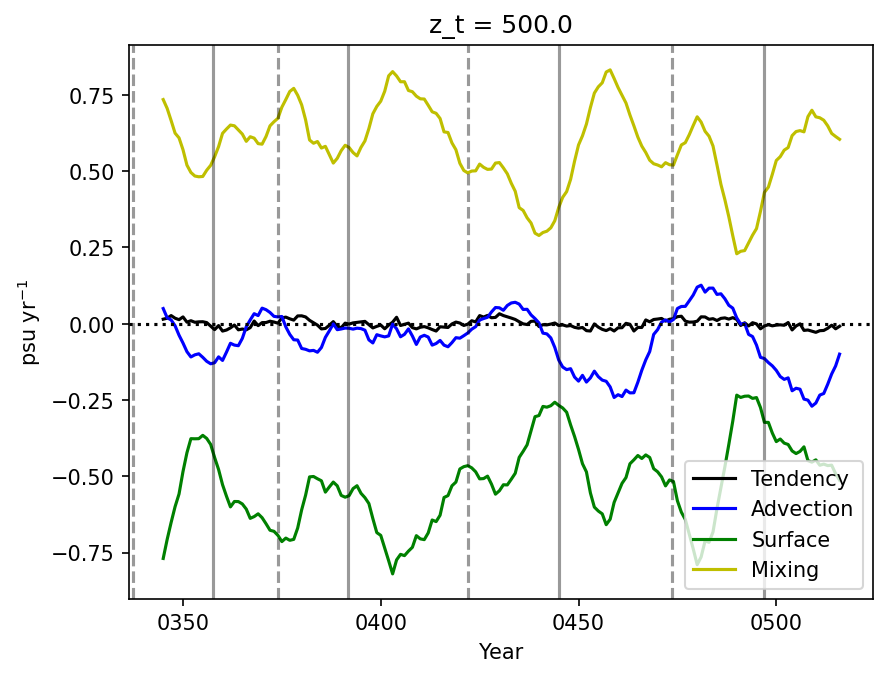

In [44]:
plt.figure(dpi=150)
(spy*(crb_dsdt_ts.rolling(time=10, center=True).mean())).plot(color='k', label='Tendency')
(spy*(advection_ts2.rolling(time=10, center=True).mean())).plot(color='b', label='Advection')
(spy*(sfc_flux_50m_ts.rolling(time=10, center=True).mean())).plot(color='g', label='Surface')
(spy*(residual_ts.rolling(time=10, center=True).mean())).plot(color='y', label='Mixing')
plt.axhline(color='k', linestyle=':')
plot_lfc_ext(4)
plt.ylabel('psu yr$^{-1}$')
plt.xlabel('Year')
plt.legend()

In [45]:
pearsonr(rolling_mean(advection_ts2), rolling_mean(crb_dsdt_ts))

PearsonRResult(statistic=np.float64(0.8208419992538045), pvalue=np.float64(3.152968276247162e-16))

In [46]:
pearsonr(rolling_mean(vert_adv_ts), rolling_mean(crb_dsdt_ts))

PearsonRResult(statistic=np.float64(0.04395186016335571), pvalue=np.float64(0.7344603829153584))

In [47]:
pearsonr(rolling_mean(vert_adv_ts2), rolling_mean(crb_dsdt_ts))

PearsonRResult(statistic=np.float64(0.0439519975712842), pvalue=np.float64(0.7344595833302601))

In [48]:
pearsonr(rolling_mean(horiz_adv_ts), rolling_mean(crb_dsdt_ts))

PearsonRResult(statistic=np.float64(-0.024256579128688553), pvalue=np.float64(0.8515532098486568))

In [49]:
pearsonr(rolling_mean(horiz_adv_ts2), rolling_mean(crb_dsdt_ts))

PearsonRResult(statistic=np.float64(-0.02425682230855216), pvalue=np.float64(0.8515517384811218))

In [50]:
pearsonr(rolling_mean(sfc_flux_50m_ts), rolling_mean(crb_dsdt_ts))

PearsonRResult(statistic=np.float64(-0.27287866363754015), pvalue=np.float64(0.03188672916704129))

In [51]:
pearsonr(rolling_mean(residual_ts), rolling_mean(crb_dsdt_ts))

PearsonRResult(statistic=np.float64(-0.06448786686723813), pvalue=np.float64(0.6185100995385057))

Text(0.28, 1.05, '$r=-0.06$')

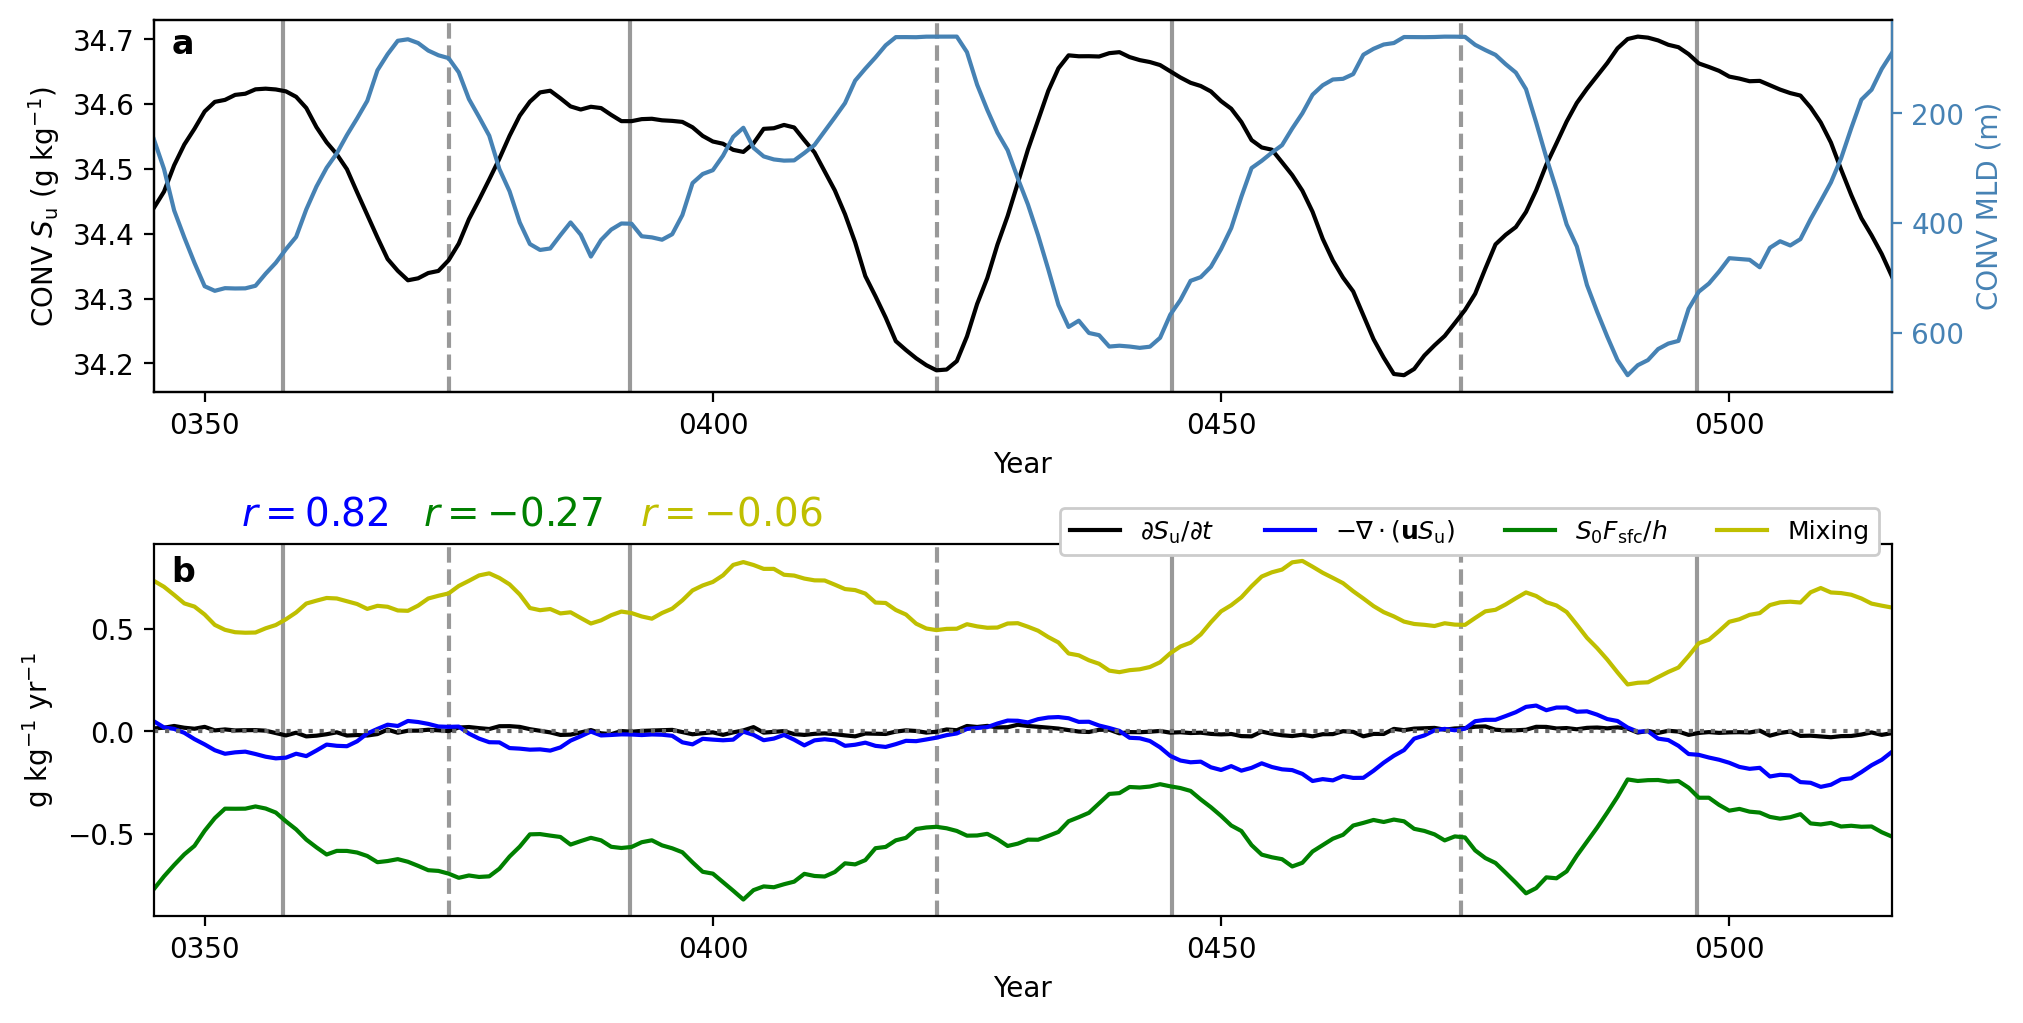

In [52]:
proj = ccrs.Robinson(central_longitude=30)
proj._threshold /= 100.

# fig, ax = plt.subplots(2, 2, dpi=300, figsize=(12, 6), layout='constrained')


fig1 = plt.figure(1, dpi=200, figsize=(10, 5), constrained_layout=True)
ax = fig1.subplot_mosaic(
    '''
    AA
    AA
    CC
    CC
    '''
)
ax2 = ax['A'].twinx()
# fig1.delaxes(ax['B'])
# fig1.delaxes(ax['E'])

# annual_rm(mls.SALT).plot(ax=ax['A'], color='k', linewidth=1.5
annual_rm(cr_salt_ts_ds.SALT).plot(ax=ax['A'], color='k')
annual_rm(mld_subset.where(crmask).weighted(tarea).mean(dim=['nlat', 'nlon'])/100).plot(ax=ax2, yincrease=False, color='steelblue')
plot_lfc_ext(4, ax['A'])
ax['A'].set_ylabel(r'CONV $S_\mathrm{u}$ (g kg$^{-1}$)')
ax2.set_ylabel(r'CONV MLD (m)')
ax2.spines['right'].set_color('steelblue')
ax2.yaxis.label.set_color('steelblue')
ax2.tick_params(axis='y', colors='steelblue')
ax['A'].set_xlim(crb_dsdt_ts.time.sel(time='0344').values, crb_dsdt_ts.time.sel(time='0515').values)
# ax['A'].set_xticklabels([])
ax['A'].set_title('')
ax2.set_title('')
ax['A'].set_xlabel('Year')

# fig1.delaxes(ax['B'])
# ax_map = fig1.add_subplot(2, 2, 2, projection=proj)
# ax_map.set_extent([-20, 70, -75, -25])
# lons, lats, mld = z_masked_overlap(ax_map, mld_clim.TLONG.data, mld_clim.TLAT.data, mld_clim.data, source_projection=ccrs.Geodetic())
# mld_map = ax_map.contourf(lons, lats, mld, levels=21, cmap='Blues')
# ax_map.contour(lons, lats, mld, levels=[250], colors='k', linewidths=1.5)
# plt.colorbar(mld_map, ax=ax_map, label='Average MLD (m)', location='left', shrink=0.9, pad=-0.1)
# ax_map.coastlines(linewidth=0.5, zorder=-1)
# gl = ax_map.gridlines(linewidth=0.75, linestyle=':', alpha=0.9, ylim=80, ylocs=np.arange(-80, -29, 10), xlocs=np.arange(-80, 81, 20))
# gl.top_labels = True
# gl.right_labels = True
# ax_map.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'), color='0.3', zorder=-1)
# ax_map.add_patch(mpatches.Polygon(xy=([0, -70], [60, -70], [60, -30], [0, -30]), facecolor='none', edgecolor='darkblue', linewidth=1.5, transform=ccrs.PlateCarree()))
# ax_map.scatter(2.7, -65, marker='*', s=70, color='yellow', edgecolors='black', linewidths=0.25, alpha=1, transform=ccrs.PlateCarree(), zorder=3)

plot_lfc_ext(4, ax['C'])
(spy*(crb_dsdt_ts.rolling(time=10, center=True).mean())).plot(ax=ax['C'], color='k', label=r'$\partial S_\mathrm{u}/\partial t$')
(spy*(advection_ts2.rolling(time=10, center=True).mean())).plot(ax=ax['C'], color='b', label=r'$-\nabla\cdot(\mathbf{u}S_\mathrm{u})$')
(spy*(sfc_flux_50m_ts.rolling(time=10, center=True).mean())).plot(ax=ax['C'], color='g', label=r'$S_0F_\mathrm{sfc}/h$')
(spy*(residual_ts.rolling(time=10, center=True).mean())).plot(ax=ax['C'], color='y', label='Mixing')
# (0.01*spy*(vert_adv_ts.rolling(time=10, center=True).mean())).plot(ax=ax['C'], color='b', linestyle=':')
# (0.01*spy*(horiz_adv_ts.rolling(time=10, center=True).mean())).plot(ax=ax['C'], color='b', linestyle='--')

ax['C'].axhline(linestyle=':', color='0.4')
ax['C'].set_ylabel('g kg$^{-1}$ yr$^{-1}$')
ax['C'].set_xlabel('Year')
ax['C'].legend(loc='upper right', ncols=4, fontsize=9, bbox_to_anchor=(1.0, 1.13), framealpha=1.0)
ax['C'].set_xlim(crb_dsdt_ts.time.sel(time='0344').values, crb_dsdt_ts.time.sel(time='0515').values)
ax['C'].set_title('')

# ax['D'].axhline(0, linestyle=':', color='0.4')
# ax['D'].axvline(0, linestyle=':', color='0.4')
# ax['D'].plot(lags, adv_tend_lagcorr, color='b', label=r'$-\nabla\cdot(\mathbf{u}S_\mathrm{u})$')
# ax['D'].plot(lags, sfc_tend_lagcorr, color='g', label=r'$S_0F_\mathrm{sfc}/h$')
# ax['D'].plot(lags, mix_tend_lagcorr, color='y', label='Mixing')
# ax['D'].set_ylabel(r'Correlation with $\partial S_\mathrm{u}/\partial t$')
# ax['D'].set_xlabel('Lag (yr)')
# ax['D'].legend(loc='lower left', fontsize=9)
# ax['D'].set_xlim(-30, 30)

ax['A'].annotate('a', xy=(0.01, 0.91), xycoords='axes fraction', fontweight='bold', size=12)
# ax_map.annotate('b', xy=(0.03, 0.91), xycoords='axes fraction', fontweight='bold', size=12)
ax['C'].annotate('b', xy=(0.01, 0.9), xycoords='axes fraction', fontweight='bold', size=12)
# ax['D'].annotate('c', xy=(0.035, 0.91), xycoords='axes fraction', fontweight='bold', size=12)
# ax['D'].annotate(r'$\partial S_\mathrm{u}/\partial t$ lags $\longleftarrow$', xy=(0.12, 0.9), xycoords='axes fraction')
# ax_map.annotate('Fig. 4', xy=(0.71, 0.83), xycoords='axes fraction', fontweight='bold', c='darkblue', size=10)
# ax_map.annotate('CONV', xy=(0.32, 0.26), xycoords='axes fraction', fontweight='bold', c='k', size=10)

ax['C'].annotate('$r=%.2f$' %pearsonr(rolling_mean(advection_ts2), rolling_mean(crb_dsdt_ts))[0], xy=(0.05, 1.05), xycoords='axes fraction', size=14, color='b')
ax['C'].annotate('$r=%.2f$' %pearsonr(rolling_mean(sfc_flux_50m_ts), rolling_mean(crb_dsdt_ts))[0], xy=(0.155, 1.05), xycoords='axes fraction', size=14, color='g')
ax['C'].annotate('$r=%.2f$' %pearsonr(rolling_mean(residual_ts), rolling_mean(crb_dsdt_ts))[0], xy=(0.28, 1.05), xycoords='axes fraction', size=14, color='y')

Text(0.28, 1.05, '$r=-0.06$')

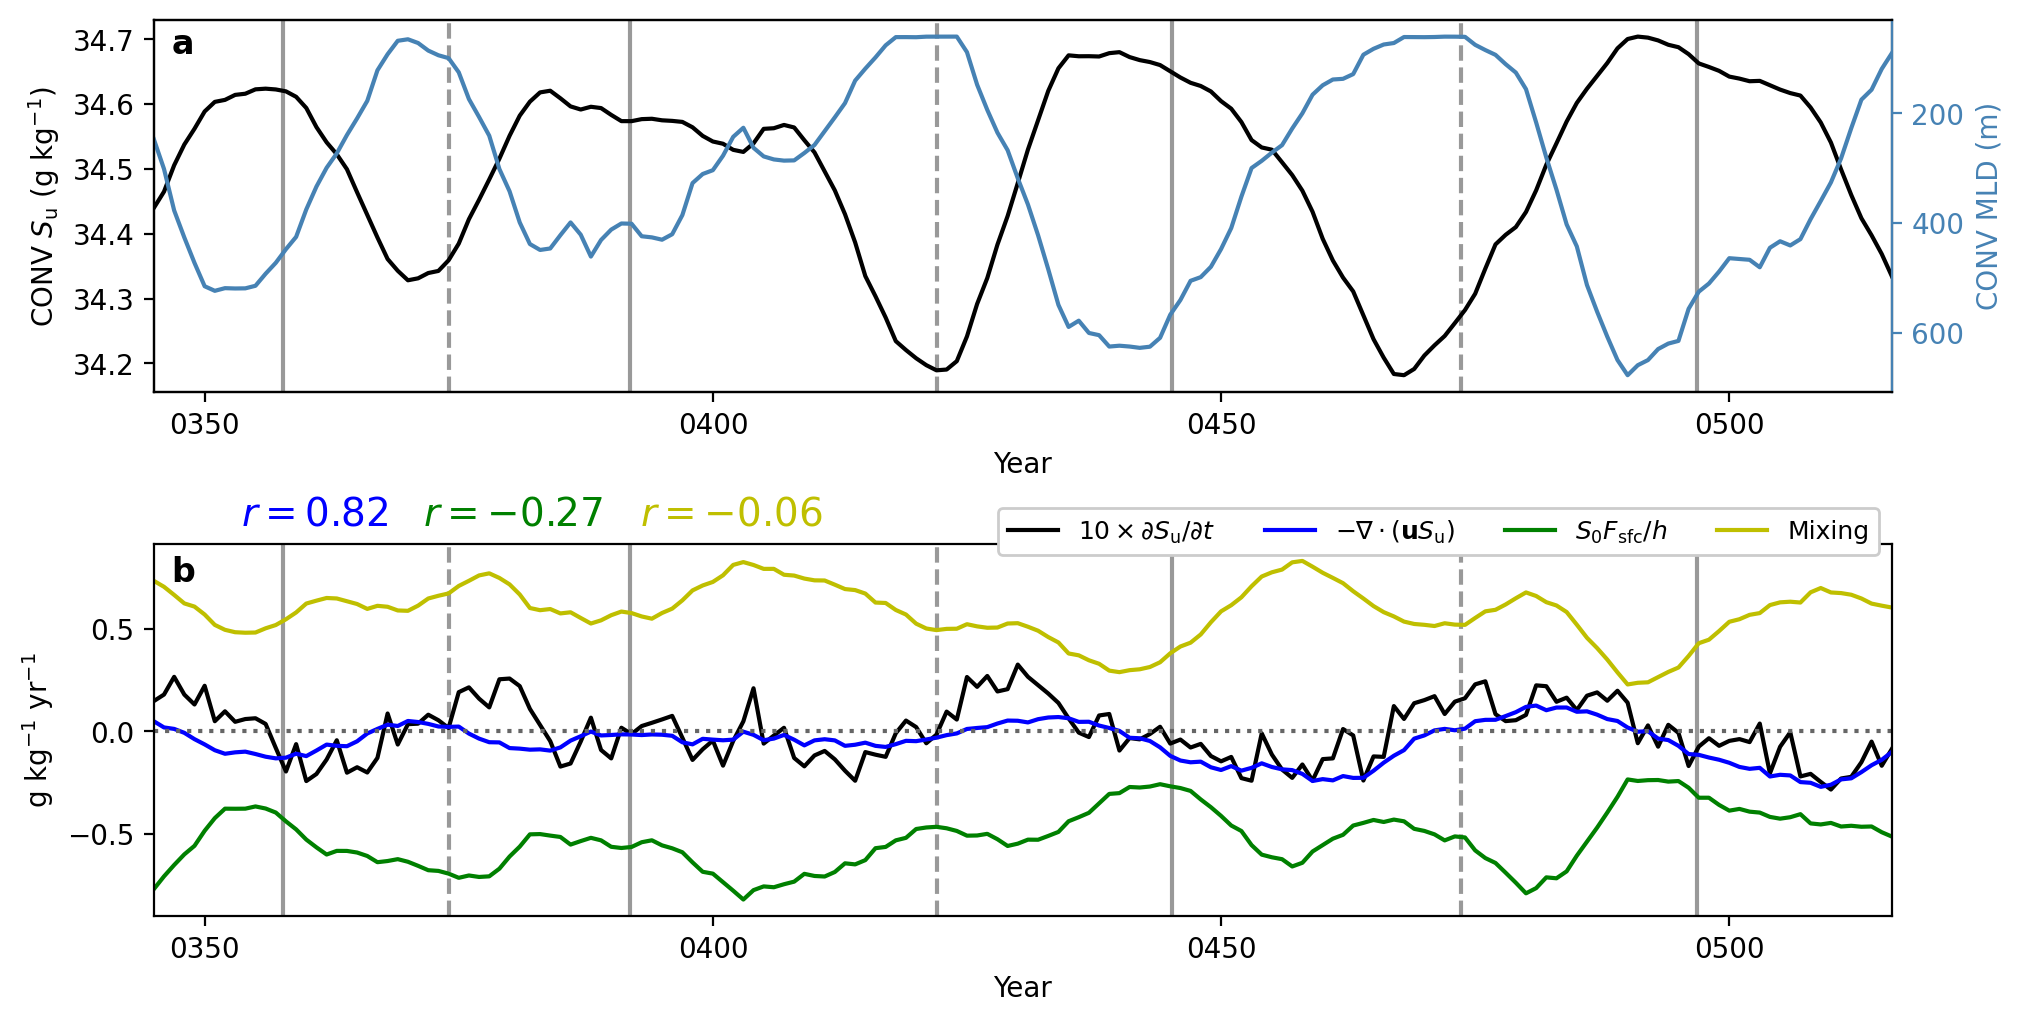

In [53]:
proj = ccrs.Robinson(central_longitude=30)
proj._threshold /= 100.

# fig, ax = plt.subplots(2, 2, dpi=300, figsize=(12, 6), layout='constrained')


fig1 = plt.figure(1, dpi=200, figsize=(10, 5), constrained_layout=True)
ax = fig1.subplot_mosaic(
    '''
    AA
    AA
    CC
    CC
    '''
)
ax2 = ax['A'].twinx()
# fig1.delaxes(ax['B'])
# fig1.delaxes(ax['E'])

# annual_rm(mls.SALT).plot(ax=ax['A'], color='k', linewidth=1.5
annual_rm(cr_salt_ts_ds.SALT).plot(ax=ax['A'], color='k')
annual_rm(mld_subset.where(crmask).weighted(tarea).mean(dim=['nlat', 'nlon'])/100).plot(ax=ax2, yincrease=False, color='steelblue')
plot_lfc_ext(4, ax['A'])
ax['A'].set_ylabel(r'CONV $S_\mathrm{u}$ (g kg$^{-1}$)')
ax2.set_ylabel(r'CONV MLD (m)')
ax2.spines['right'].set_color('steelblue')
ax2.yaxis.label.set_color('steelblue')
ax2.tick_params(axis='y', colors='steelblue')
ax['A'].set_xlim(crb_dsdt_ts.time.sel(time='0344').values, crb_dsdt_ts.time.sel(time='0515').values)
# ax['A'].set_xticklabels([])
ax['A'].set_title('')
ax2.set_title('')
ax['A'].set_xlabel('Year')

# fig1.delaxes(ax['B'])
# ax_map = fig1.add_subplot(2, 2, 2, projection=proj)
# ax_map.set_extent([-20, 70, -75, -25])
# lons, lats, mld = z_masked_overlap(ax_map, mld_clim.TLONG.data, mld_clim.TLAT.data, mld_clim.data, source_projection=ccrs.Geodetic())
# mld_map = ax_map.contourf(lons, lats, mld, levels=21, cmap='Blues')
# ax_map.contour(lons, lats, mld, levels=[250], colors='k', linewidths=1.5)
# plt.colorbar(mld_map, ax=ax_map, label='Average MLD (m)', location='left', shrink=0.9, pad=-0.1)
# ax_map.coastlines(linewidth=0.5, zorder=-1)
# gl = ax_map.gridlines(linewidth=0.75, linestyle=':', alpha=0.9, ylim=80, ylocs=np.arange(-80, -29, 10), xlocs=np.arange(-80, 81, 20))
# gl.top_labels = True
# gl.right_labels = True
# ax_map.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m'), color='0.3', zorder=-1)
# ax_map.add_patch(mpatches.Polygon(xy=([0, -70], [60, -70], [60, -30], [0, -30]), facecolor='none', edgecolor='darkblue', linewidth=1.5, transform=ccrs.PlateCarree()))
# ax_map.scatter(2.7, -65, marker='*', s=70, color='yellow', edgecolors='black', linewidths=0.25, alpha=1, transform=ccrs.PlateCarree(), zorder=3)

plot_lfc_ext(4, ax['C'])
(10*spy*(crb_dsdt_ts.rolling(time=10, center=True).mean())).plot(ax=ax['C'], color='k', label=r'$10\times\partial S_\mathrm{u}/\partial t$')
(spy*(advection_ts2.rolling(time=10, center=True).mean())).plot(ax=ax['C'], color='b', label=r'$-\nabla\cdot(\mathbf{u}S_\mathrm{u})$')
(spy*(sfc_flux_50m_ts.rolling(time=10, center=True).mean())).plot(ax=ax['C'], color='g', label=r'$S_0F_\mathrm{sfc}/h$')
(spy*(residual_ts.rolling(time=10, center=True).mean())).plot(ax=ax['C'], color='y', label='Mixing')
# (0.01*spy*(vert_adv_ts.rolling(time=10, center=True).mean())).plot(ax=ax['C'], color='b', linestyle=':')
# (0.01*spy*(horiz_adv_ts.rolling(time=10, center=True).mean())).plot(ax=ax['C'], color='b', linestyle='--')

ax['C'].axhline(linestyle=':', color='0.4')
ax['C'].set_ylabel('g kg$^{-1}$ yr$^{-1}$')
ax['C'].set_xlabel('Year')
ax['C'].legend(loc='upper right', ncols=4, fontsize=9, bbox_to_anchor=(1.0, 1.13), framealpha=1.0)
ax['C'].set_xlim(crb_dsdt_ts.time.sel(time='0344').values, crb_dsdt_ts.time.sel(time='0515').values)
ax['C'].set_title('')

# ax['D'].axhline(0, linestyle=':', color='0.4')
# ax['D'].axvline(0, linestyle=':', color='0.4')
# ax['D'].plot(lags, adv_tend_lagcorr, color='b', label=r'$-\nabla\cdot(\mathbf{u}S_\mathrm{u})$')
# ax['D'].plot(lags, sfc_tend_lagcorr, color='g', label=r'$S_0F_\mathrm{sfc}/h$')
# ax['D'].plot(lags, mix_tend_lagcorr, color='y', label='Mixing')
# ax['D'].set_ylabel(r'Correlation with $\partial S_\mathrm{u}/\partial t$')
# ax['D'].set_xlabel('Lag (yr)')
# ax['D'].legend(loc='lower left', fontsize=9)
# ax['D'].set_xlim(-30, 30)

ax['A'].annotate('a', xy=(0.01, 0.91), xycoords='axes fraction', fontweight='bold', size=12)
# ax_map.annotate('b', xy=(0.03, 0.91), xycoords='axes fraction', fontweight='bold', size=12)
ax['C'].annotate('b', xy=(0.01, 0.9), xycoords='axes fraction', fontweight='bold', size=12)
# ax['D'].annotate('c', xy=(0.035, 0.91), xycoords='axes fraction', fontweight='bold', size=12)
# ax['D'].annotate(r'$\partial S_\mathrm{u}/\partial t$ lags $\longleftarrow$', xy=(0.12, 0.9), xycoords='axes fraction')
# ax_map.annotate('Fig. 4', xy=(0.71, 0.83), xycoords='axes fraction', fontweight='bold', c='darkblue', size=10)
# ax_map.annotate('CONV', xy=(0.32, 0.26), xycoords='axes fraction', fontweight='bold', c='k', size=10)

ax['C'].annotate('$r=%.2f$' %pearsonr(rolling_mean(advection_ts2), rolling_mean(crb_dsdt_ts))[0], xy=(0.05, 1.05), xycoords='axes fraction', size=14, color='b')
ax['C'].annotate('$r=%.2f$' %pearsonr(rolling_mean(sfc_flux_50m_ts), rolling_mean(crb_dsdt_ts))[0], xy=(0.155, 1.05), xycoords='axes fraction', size=14, color='g')
ax['C'].annotate('$r=%.2f$' %pearsonr(rolling_mean(residual_ts), rolling_mean(crb_dsdt_ts))[0], xy=(0.28, 1.05), xycoords='axes fraction', size=14, color='y')

In [55]:
fig1.savefig('salt-budget.pdf')